# LSTM

I found that the classical ML approach is good; however, the models seem to cap at a weighted average score of 0.75 on the test dataset. I am going to try utilizing deep learning approaches to better tackle the problem

In [ ]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torchtext
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score
import torchtext
from torchtext.data.utils import get_tokenizer
from nltk.stem import SnowballStemmer
import re
from collections import Counter, OrderedDict
import tensorflow as tf

tqdm.pandas()

# Getting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Getting the data
# For Google Colab
training_data = pd.read_csv('train.csv')[['essay','LLM_written']]
valid_data = pd.read_csv('validation.csv')[['essay','LLM_written']]

## Preprocessing

1. Convert Contractions to Full Form -> I am going to convert contractions to full form so that contractions aren't treated differently.
2. I will then tokenize the words using the Spacy Tokenizer.
3. Stemming because lemmatization will take a long time.

In [ ]:
# Creating a dictionary for the contradictions
# Dictionary is from https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = {
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
# Getting the tokenizer
tokenizer = get_tokenizer('spacy',language='en_core_web_sm')

# Getting the stemmer
stemmer = SnowballStemmer(language='english')

In [ ]:
# A function for preprocessing
def preprocess(essay:str):
    preprocessed_essay = essay.lower()


    # Iterating through the contractions and replacing the
    for contraction in contractions.keys():
        preprocessed_essay = re.sub(contraction.lower(),contractions[contraction].lower(),preprocessed_essay)

    # Subbing out \n and \t
    preprocessed_essay = re.sub("\n","",preprocessed_essay)
    preprocessed_essay = re.sub("\t","",preprocessed_essay)

    # Replacing /xa0 = non-breaking space in Latin1
    preprocessed_essay = preprocessed_essay.replace(u'\xa0', u' ')

    final_preprocessed_essay = []

    # Running through tokenizer and returning the non-whitespace tokens
    for token in tokenizer(preprocessed_essay):
        temp_token = token.strip(" ")

        if temp_token != "":
            final_preprocessed_essay.append(stemmer.stem(token))

    return final_preprocessed_essay

In [ ]:
# Running the training essays and validation essays through preprocessing
train_essays = training_data['essay'].progress_apply(preprocess)

100%|██████████| 44733/44733 [04:24<00:00, 169.06it/s]


In [ ]:
# Running the validation essays through preprocessing
valid_essays = valid_data['essay'].progress_apply(preprocess)

100%|██████████| 5195/5195 [01:10<00:00, 74.21it/s]


In [ ]:
# Putting the unique tokens into a counter with {token:count}
unique_tokens = Counter(token for essay in train_essays for token in set(essay))

In [ ]:
# Putting the unique tokens into an ordered dict
unique_tokens_dict = OrderedDict(unique_tokens.most_common()[:25000])

# Checking how many tokens I have
len(unique_tokens_dict)

25000

In [ ]:
# Making the vocabulary
vocabulary = torchtext.vocab.vocab(unique_tokens_dict,specials=['<unk>','<pad>'],special_first=True)

# Setting the default index
vocabulary.set_default_index(vocabulary['<unk>'])

In [ ]:
# Saving the vocabulary
torch.save(vocabulary,'vocab.pt')

In [ ]:
# Function to put each essay through the vocabulary
def put_through_vocab(essay:str) -> list:
  return vocabulary(essay)

# Indexed
indexed_essays_train = [put_through_vocab(essay) for essay in train_essays]
indexed_essays_valid = [put_through_vocab(essay) for essay in valid_essays]

In [ ]:
# Padding the essays
train_padded = tf.keras.utils.pad_sequences(indexed_essays_train,maxlen=512,padding='post',truncating='post',value=vocabulary['<pad>'])
valid_padded = tf.keras.utils.pad_sequences(indexed_essays_valid,maxlen=512,padding='post',truncating='post',value=vocabulary['<pad>'])

In [ ]:
# Creating the dataloaders
X_train_tensor = torch.from_numpy(train_padded)
y_train_tensor = torch.from_numpy(training_data['LLM_written'].values)
X_valid_tensor = torch.from_numpy(valid_padded)
y_valid_tensor = torch.from_numpy(valid_data['LLM_written'].values)
training_dataset = TensorDataset(X_train_tensor,y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor,y_valid_tensor)
training_loader = DataLoader(training_dataset,batch_size=32,shuffle=True)
valid_loader = DataLoader(training_dataset,batch_size=32,shuffle=True)

## Model

Data is prepared and ready to be used for training. Now, I need to build the model.

In [ ]:
# Class for the model
class LSTM(nn.Module):
  # Constructor
  def __init__(self,vocab_size,embedding_dim=256,hidden_size=100,dropout=0.2,bidirect=False):
    super().__init__()

    # Creating the layers
    self.embedding = nn.Embedding(vocab_size,embedding_dim,padding_idx=vocabulary['<pad>'])
    self.lstm = nn.LSTM(embedding_dim,hidden_size,num_layers=2,bias=True,batch_first=True,bidirectional=bidirect)
    if bidirect:
      self.output = nn.Linear(hidden_size*2,1,bias=True)
    else:
      self.output = nn.Linear(hidden_size,1,bias=True)
    self.dropout = nn.Dropout(dropout)

  # Forward Pass
  def forward(self,X):
    # Running X through the embedding
    output = self.embedding(X)

    # Running the embedding through the LSTM
    output, (_,_) = self.lstm(output)

    # Running the final output through the linear classifier
    output = self.output(self.dropout(output[:,-1,:]))
    return nn.functional.sigmoid(output)

In [ ]:
# Setting up the model
lstm = LSTM(len(vocabulary),embedding_dim=512,hidden_size=256,bidirect=True)
lstm.to(device)

LSTM(
  (embedding): Embedding(25002, 512, padding_idx=1)
  (lstm): LSTM(512, 256, num_layers=2, batch_first=True, bidirectional=True)
  (output): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
# Setting up the model training parameters
EPOCHS = 100
LEARNING_RATE = 0.003
LOSS = nn.BCELoss()
OPTIMIZER = torch.optim.Adam(lstm.parameters(),LEARNING_RATE)
history = []
early_stopping_threshold = 10
best_roc_auc = 0
current_count = 0

In [ ]:
for epoch in range(EPOCHS):
    train_loss = 0
    train_preds = None
    valid_preds = None
    train_targets = None
    valid_targets = None
    lstm.train()
    for X,y in training_loader:
        # Making predictions
        y = y.to(torch.float32)
        # Putting the tensors on the right device
        X = X.to(device)
        y = y.to(device)

        pred = lstm(X)
        if train_preds is None:
            train_preds = pred.cpu().detach().numpy()
        else:
            train_preds = np.append(train_preds,pred.cpu().detach().numpy(),axis=0)

        # Getting the targets
        if train_targets is None:
            train_targets = y.cpu().numpy()
        else:
            train_targets = np.append(train_targets,y.cpu().detach().numpy(),axis=0)

        # Getting the loss
        loss = LOSS(pred,y.view(-1,1))

        # Calculating the gradients
        loss.backward()

        # Taking a step with the optimizer
        OPTIMIZER.step()

        # Clear the gradients
        OPTIMIZER.zero_grad()

        # Adding the loss
        train_loss += loss.item()

    # Going through a validation loop
    lstm.eval()
    val_loss = 0
    for X,y in valid_loader:
        # Making predictions
        X = X.to(device)
        y = y.to(device)
        y = y.to(torch.float32)

        with torch.no_grad():
            pred = lstm(X)
            loss = LOSS(pred,y.view(-1,1))

        val_loss += loss.item()
        if valid_preds is None:
            valid_preds = pred.cpu().detach().numpy()
        else:
            valid_preds = np.append(valid_preds,pred.cpu().detach().numpy(),axis=0)

        # Getting the targets
        if valid_targets is None:
            valid_targets = y.cpu().numpy()
        else:
            valid_targets = np.append(valid_targets,y.cpu().detach().numpy(),axis=0)

    # Early Stopping
    if roc_auc_score(valid_targets,valid_preds) - best_roc_auc > 1e-4:
        best_roc_auc = roc_auc_score(valid_targets,valid_preds)
        count = 0

        # Saving the best model
        torch.save(lstm.state_dict(),'bidirect-2-layer-lstm.pt')
    else:
        count += 1

    # Appending the average example loss to the history
    print(f'----------EPOCH {epoch} loss----------')
    print(f'Train Loss: {train_loss / len(training_loader)}')
    print(f'Valid Loss: {val_loss / len(valid_loader)}')
    print(f'Training ROC AUC: {roc_auc_score(train_targets,train_preds)}')
    print(f'Validation ROC AUC: {roc_auc_score(valid_targets,valid_preds)}')
    history.append([train_loss / len(training_loader),val_loss / len(valid_loader),roc_auc_score(train_targets,train_preds),roc_auc_score(valid_targets,valid_preds)])
    print('--------------------------------------')
    print()

    # Stopping the loop
    if count == 10:
        print('Found no improvement!')
        break

----------EPOCH 0 loss----------
Train Loss: 0.1782407711634082
Valid Loss: 0.031515600614933206
Training ROC AUC: 0.9783330429493373
Validation ROC AUC: 0.9991519891001359
--------------------------------------

----------EPOCH 1 loss----------
Train Loss: 0.037747919981047116
Valid Loss: 0.02185873902185976
Training ROC AUC: 0.9986092701586481
Validation ROC AUC: 0.9994609635033861
--------------------------------------

----------EPOCH 2 loss----------
Train Loss: 0.02262481187011799
Valid Loss: 0.008454969621581796
Training ROC AUC: 0.9993491111301605
Validation ROC AUC: 0.9999163912230298
--------------------------------------

----------EPOCH 3 loss----------
Train Loss: 0.0210212412153052
Valid Loss: 0.009977963845649121
Training ROC AUC: 0.999457608266957
Validation ROC AUC: 0.9999219678052376
--------------------------------------

----------EPOCH 4 loss----------
Train Loss: 0.010314909042535509
Valid Loss: 0.004191451683159871
Training ROC AUC: 0.9998140505725165
Validation 

In [ ]:
# Putting the history into a dataframe for plotting
history_df = pd.DataFrame(history,columns=['Training Loss','Validation Loss','Training ROC AUC','Validation ROC AUC'])

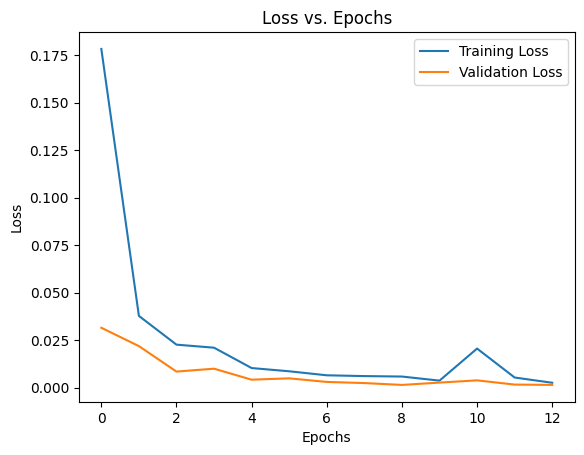

In [ ]:
# Plotting the loss
history_df[['Training Loss','Validation Loss']].plot(title='Loss vs. Epochs',xlabel='Epochs',ylabel='Loss')
plt.show()

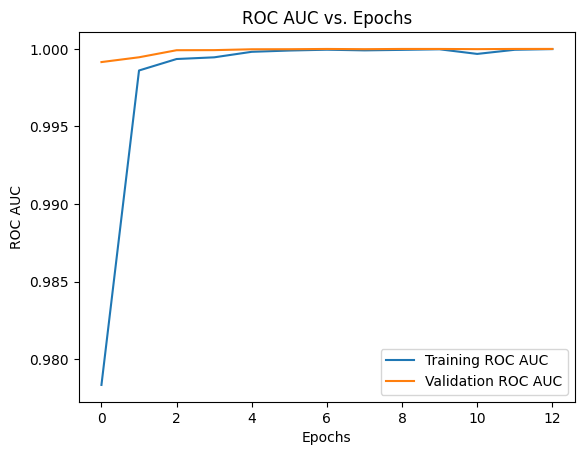

In [ ]:
# Plotting the ROC AUC
history_df[['Training ROC AUC','Validation ROC AUC']].plot(title='ROC AUC vs. Epochs',xlabel='Epochs',ylabel='ROC AUC')
plt.show()

In [ ]:
# Loading the best model
best_model = LSTM(len(vocabulary),embedding_dim=512,hidden_size=256,bidirect=True)
best_model.load_state_dict(torch.load('bidirect-2-layer-lstm.pt'))
best_model.to(device)

LSTM(
  (embedding): Embedding(25002, 512, padding_idx=1)
  (lstm): LSTM(512, 256, num_layers=2, batch_first=True, bidirectional=True)
  (output): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
# Inference loop
with torch.no_grad():
    best_model.eval()
    train_preds = None
    val_preds = None
    train_targets = None
    val_targets = None
    for X,y in training_loader:
        # Making predictions
        X = X.to(device)
        pred = best_model(X)
        if train_preds is None:
            train_preds = pred.cpu().detach().numpy()
        else:
            train_preds = np.append(train_preds,pred.cpu().detach().numpy(),axis=0)

        # Getting the targets
        if train_targets is None:
            train_targets = y.cpu().numpy()
        else:
            train_targets = np.append(train_targets,y.cpu().detach().numpy(),axis=0)
    for X,y in valid_loader:
        # Making predictions
        X = X.to(device)
        pred = best_model(X)
        if valid_preds is None:
            valid_preds = pred.cpu().detach().numpy()
        else:
            valid_preds = np.append(valid_preds,pred.cpu().detach().numpy(),axis=0)

        # Getting the targets
        if valid_targets is None:
            valid_targets = y.numpy()
        else:
            valid_targets = np.append(valid_targets,y.detach().numpy(),axis=0)

In [ ]:
# Making predictions
print('Predictions for LSTM')
train_score = roc_auc_score(train_targets,train_preds)
valid_score = roc_auc_score(valid_targets,valid_preds)
print(f'Training ROC AUC: {train_score}')
print(f'Validation ROC AUC: {valid_score}')

Predictions for LSTM
Training ROC AUC: 0.9999163912230298
Validation ROC AUC: 0.9999750924720221


In [ ]:
# Creating a dictionary for the model performances
performances = {
    'model':[],
    'Train ROC AUC':[],
    'Valid ROC AUC':[]
}

In [ ]:
# Adding the metrics
model = 'LSTM'
performances['model'].append(model)
performances['Train ROC AUC'].append(train_score)
performances['Valid ROC AUC'].append(valid_score)

In [ ]:
# Printing out the model performances in a dataframe and saving it
metrics_df = pd.DataFrame().from_dict(performances)
metrics_df

,model,Train ROC AUC,Valid ROC AUC
0,LSTM,0.999899,0.999885


In [ ]:
# Saving the performances
metrics_df.to_csv('metrics.csv',index=False)